In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
all_classes = Base.classes.keys()
print(f"AutoLoad found {all_classes}")

AutoLoad found ['measurement', 'station']


In [8]:
# Save references to each table
stations = Base.classes.station

# Example query using the Measurement class
measurements = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
link = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
latestDate = link.query(func.max(measurements.date)).scalar()
latestDate

'2017-08-23'

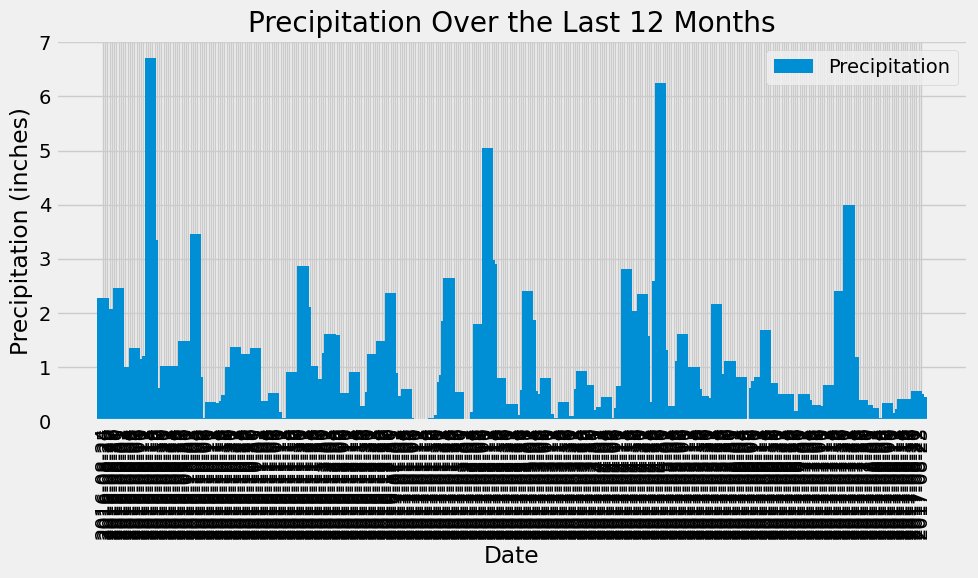

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(latestDate, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = link.query(measurements.date, measurements.prcp).filter(measurements.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')


# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(precipitation_df['Date'], precipitation_df['Precipitation'], label='Precipitation', width=5)

ax.set(title='Precipitation Over the Last 12 Months',
       xlabel='Date',
       ylabel='Precipitation (inches)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

In [12]:
pSummary = precipitation_df['Precipitation'].describe()
pSummary

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
totalStations = link.query(func.count(stations.station)).scalar()
totalStations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
mostActiveStations = link.query(measurements.station, func.count(measurements.station)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).all()

mostActiveStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = mostActiveStations[0][0] 

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = link.query(func.min(measurements.tobs),
                               func.max(measurements.tobs),
                               func.avg(measurements.tobs)).\
    filter(measurements.station == most_active_station_id).all()

# Display the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]

print(f"For the most active station (ID: {most_active_station_id}):")
print(f"Lowest Temperature: {lowest_temp} °F")
print(f"Highest Temperature: {highest_temp} °F")
print(f"Average Temperature: {avg_temp} °F")

For the most active station (ID: USC00519281):
Lowest Temperature: 54.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 71.66378066378067 °F


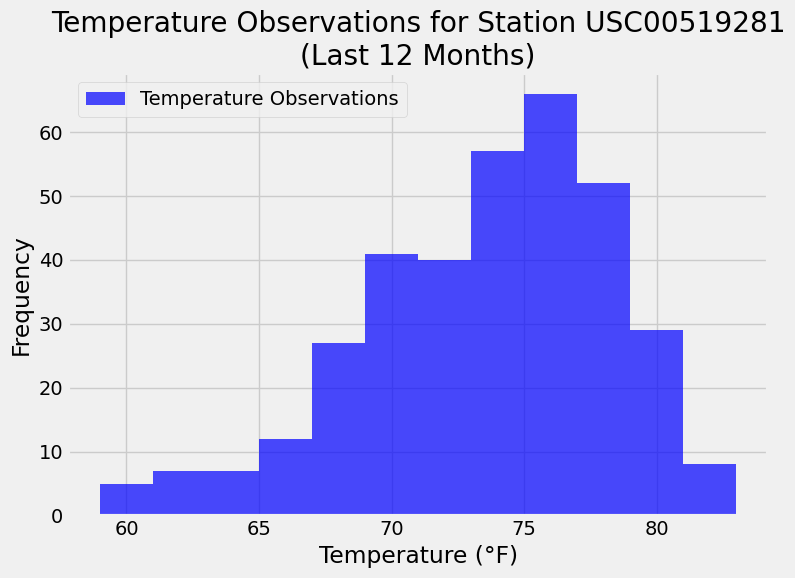

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_id = mostActiveStations[0][0]  # Assuming the first result has the most active station ID

# Design a query to retrieve the last 12 months of temperature observation data for the most active station
temperature_data = link.query(measurements.tobs).\
    filter(measurements.station == most_active_station_id).\
    filter(measurements.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Temperature'])

# Plot the results as a histogram
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(temperature_df['Temperature'], bins=12, label='Temperature Observations', alpha=0.7, color='blue')

ax.set(title=f'Temperature Observations for Station {most_active_station_id}\n(Last 12 Months)',
       xlabel='Temperature (°F)',
       ylabel='Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [17]:
# Close Session
link.close()